<a href="https://colab.research.google.com/github/Abuton/iQube-Learn-With-Us-Data-Science/blob/main/iQube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Dependencies

In [28]:
import pandas as pd

# lstm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

# logistic regression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# viz
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

Read in the datasets and checked the first 5 rows of train

data was encoded with latin the defualt encoding is 'utf-8'

In [29]:
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv')

train.head()

UserName  ...           Sentiment
0      3799  ...             Neutral
1      3800  ...            Positive
2      3801  ...            Positive
3      3802  ...            Positive
4      3803  ...  Extremely Negative

[5 rows x 6 columns]

In [30]:
print(f'There are {train.shape[0]} observations/datapoints in this case tweets in the dataset and {train.shape[1]} features describing each tweets')

There are 41157 observations/datapoints in this case tweets in the dataset and 6 features describing each tweets


how many tweets are there in the test dataset?

In [31]:
print(f'there are {test.shape[0]} tweets')

there are 3798 tweets


In [32]:
# checking for missing values
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Location is the only features with missing values

In [33]:
print(f'There are {train.Location.isnull().sum()} in train dataset')
print(f'There are {test.Location.isnull().sum()} in test dataset')

There are 8590 in train dataset
There are 834 in test dataset


### Exploratory Analysis (Univariate Analysis)

Uni-variate analysis involves only one column, esentially the goal is to understand is how the data are distributed in the column

In [34]:
# merging both the train and test together for a more in-depth analysis
df = pd.concat([train, test], ignore_index=True)

df.shape

(44955, 6)

In [35]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [36]:
df.describe()

UserName    ScreenName
count  44955.000000  44955.000000
mean   22478.000000  67430.000000
std    12977.535012  12977.535012
min        1.000000  44953.000000
25%    11239.500000  56191.500000
50%    22478.000000  67430.000000
75%    33716.500000  78668.500000
max    44955.000000  89907.000000

Intuition tells me that Features like UserName and ScreenName should be object datatype and not integers.
Reason why they are integers::
1. The data might have been encoded in compliance to data privacy
2. Information is intentionally abstracted by the data collector

More information is needed to understand and reach a conclusion as to why both columns are integers

But the result of the summary statistics are not really communicating much information

**Location: Where the Tweet is sent from**

In [37]:
print(f" The tweets were sent from {df['Location'].nunique()} different locations")

 The tweets were sent from 13137 different locations


Lots of Unique places right?

But which one (location) has the highest number of tweets?

In [38]:
# selecting top 10 locations based on tweet counts
df.Location.value_counts()[:10]

United States      603
London, England    568
London             565
New York, NY       429
Washington, DC     411
United Kingdom     355
Los Angeles, CA    314
India              283
UK                 246
USA                243
Name: Location, dtype: int64

In [39]:
a = pd.DataFrame(df.Location.value_counts()[:10]).reset_index()

px.bar(a, x='index', y='Location')

**TweetAt: When the tweet was sent**

With this column, More features could be generated like day, month etc


In [40]:
print(f"The earliest Tweet in this dataset was sent on {df['TweetAt'].min()}")
print(f"The most recent Tweet in this dataset was sent on {df['TweetAt'].max()}")

The earliest Tweet in this dataset was sent on 01-04-2020
The most recent Tweet in this dataset was sent on 31-03-2020


**Sentiment:**

In [41]:
df['Sentiment'].value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [42]:
a = pd.DataFrame(df['Sentiment'].value_counts()).reset_index()
px.bar(a, x='index', y='Sentiment')

For the Purpose of Model Building, Explainability and Ease, some sentiment values will be merge because essentially the serve the same meaning

In [43]:
def encode_sentiment(item):
    if item == "Extremely Negative" or item == "Negative":
        return 0
    elif item == "Neutral":
        return 1
    elif item == "Positive" or item == "Extremely Positive":
        return 2

Understanding the content of tweets

In [44]:
# find the most used '#' tags
import re

def hash_finder(text):
    # regex expr to find all tweets with #
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

df['hash'] = df['OriginalTweet'].apply(lambda x:hash_finder(x))

In [45]:
a = pd.DataFrame(df['hash'].value_counts()[1:20]).reset_index()

In [46]:
#Graph : Hashtags by count (without tweet withtout #)
fig = px.bar(a, orientation="v", x='index', y='hash', color_continuous_scale=px.colors.sequential.Plasma, 
             log_y=True, labels={'value':'Count', 
                                'index':'Hashtags',
                                })

fig.update_layout(
    title_text="Hashtags by count",
    font_color="black",
    title_font_color="red",
)

fig.show()

Looks like coronavirus is the most common topics amongs users in this dataset

Investigating who is the most tagged user

In [47]:
def mentions_finder(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
    
df['mention'] = df['OriginalTweet'].apply(lambda x:mentions_finder(x))

In [48]:
data = pd.DataFrame(df['mention'].value_counts()[1:20]).reset_index()
fig = px.bar(data, x='index', y='mention', orientation="v", color=df['mention'].value_counts()[1:20], color_continuous_scale=px.colors.sequential.Plasma, 
             log_y=True, labels={'value':'Count', 
                                'index':'Mentions',
                                })

fig.update_layout(
    font_color="black",
    title_font_color="red",
    title_text="Mentions by count"
)

fig.show()

Most mentioned users are **Politicians** (realDonaldTrump, BorisJohnson), **News Websites** (CNN, GoogleNews) and **Businesses** (Amazon, Tesco)

`realDonaldTrump` is the most mentioned user and no surprises, he was the president of the USA when the data was collected.

Also, all the top mentioned users are in one way or another residing, originate from USA and most tweets is from USA, so it makes sense

In [49]:
def  clean_text(df):
    # lowercase the tweets
    df["OriginalTweet"] = df["OriginalTweet"].str.lower()
    # remove all numbers, mentions, html tags etc
    df["OriginalTweet"] = df["OriginalTweet"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    
    return df

df = clean_text(df)

In [50]:
# drop the UserName and ScreenName
df = df.drop(columns=['UserName', 'ScreenName'], axis=1)
df.head()

Location  ...                       mention
0     London  ...  MeNyrbie Phil_Gahan Chrisitv
1         UK  ...                              
2  Vagabonds  ...                              
3        NaN  ...                              
4        NaN  ...                              

[5 rows x 6 columns]

In [51]:
# Examples of tweets for different sentiments
pos_sentiment = df[df['Sentiment'] == 'Positive']['OriginalTweet']
neg_sentiment = df[df['Sentiment'] == 'Negative']['OriginalTweet']
neu_sentiment = df[df['Sentiment'] == 'Neutral']['OriginalTweet']
ext_pos_sentiment = df[df['Sentiment'] == 'Extremely Positive']['OriginalTweet']
ext_neg_sentiment = df[df['Sentiment'] == 'Extremely Negative']['OriginalTweet']

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:

eng_stopwords = stopwords.words('english')
custom_stopwords = ['covid19', 'coronavirus', 'covid', 'amp']
for word in custom_stopwords:
  eng_stopwords.append(word)


def draw_wordcloud(tweets_series, sentiment):
  # word cloud visualization
  allWords = ' '.join([twts for twts in tweets_series])
  wordCloud = WordCloud(width=500, height=300, random_state=21, max_words=150, mode='RGBA',
                        max_font_size=140, stopwords=eng_stopwords).generate(allWords)
  plt.figure(figsize=(12, 9))
  plt.imshow(wordCloud, interpolation="bilinear")
  plt.axis('off')
  # plt.tight_layout()
  plt.title(f'Most used words in a {sentiment} Tweet', size=30)
  plt.show()

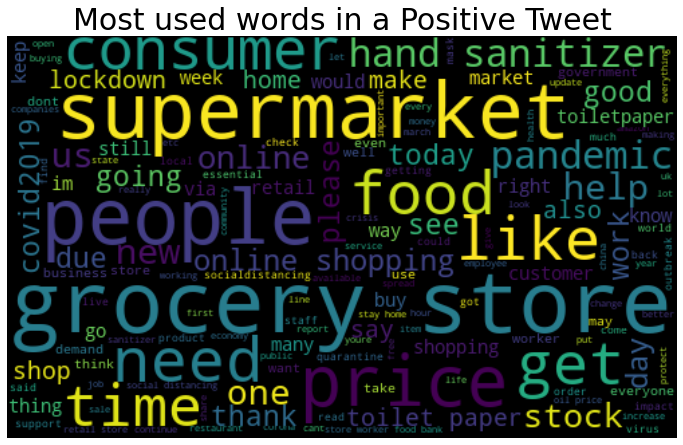

In [54]:
draw_wordcloud(pos_sentiment, 'Positive')

Most tweets is about food, grocery, supermarket

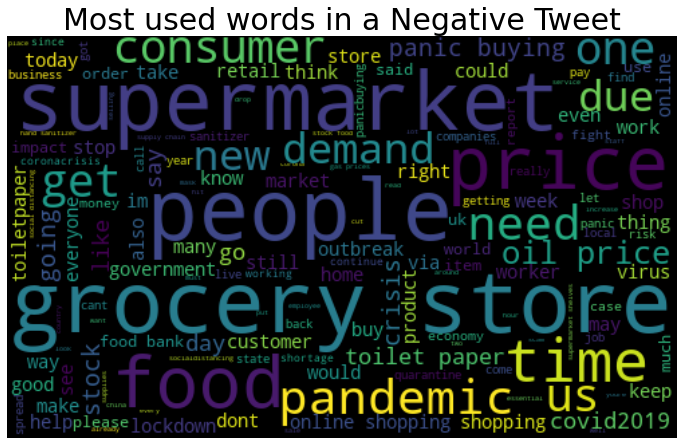

In [55]:
draw_wordcloud(neg_sentiment, 'Negative')


Well, demand, panic buying food price, crisis etc are common. It seems people are displeased about the hike in price of food

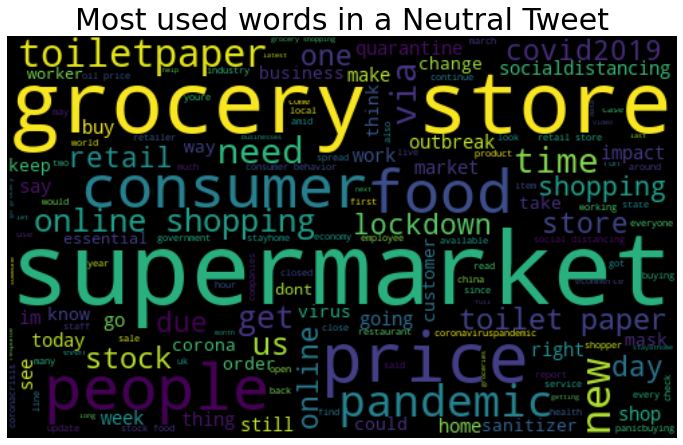

In [56]:
draw_wordcloud(neu_sentiment, 'Neutral')


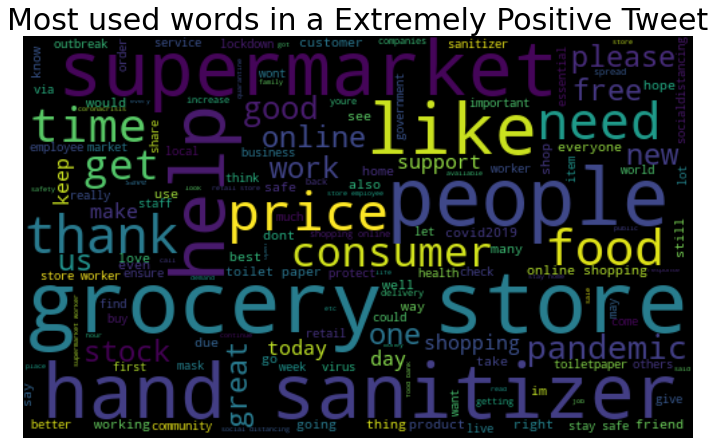

In [57]:
draw_wordcloud(ext_pos_sentiment, 'Extremely Positive')


words like 'please', 'great', 'love' were used are the most common

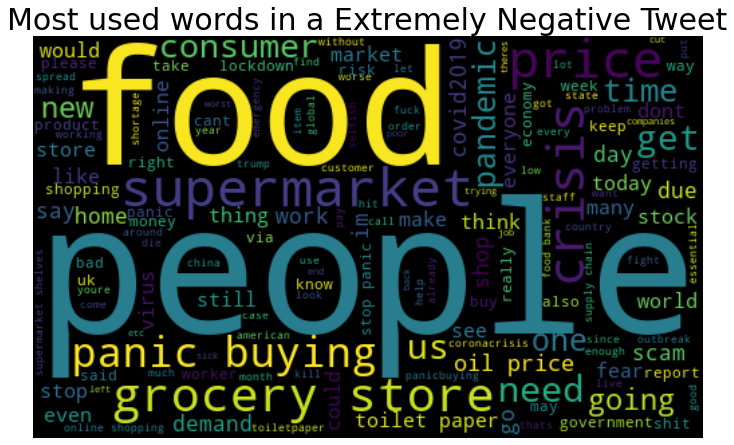

In [58]:
draw_wordcloud(ext_neg_sentiment, 'Extremely Negative')


statements like `panic buying`, `pandemic`, `scam` are the most common

Giving that there exist some similarities in the words used to describe extremely positive and positive sentiment, merging the 2 labels wont be a bad idea. Same also can be said for the extremely negative and negative labels.

So instead of building a 5 label model, it will be a 3 label

In [59]:
df["Sentiment"] = df["Sentiment"].apply(encode_sentiment)

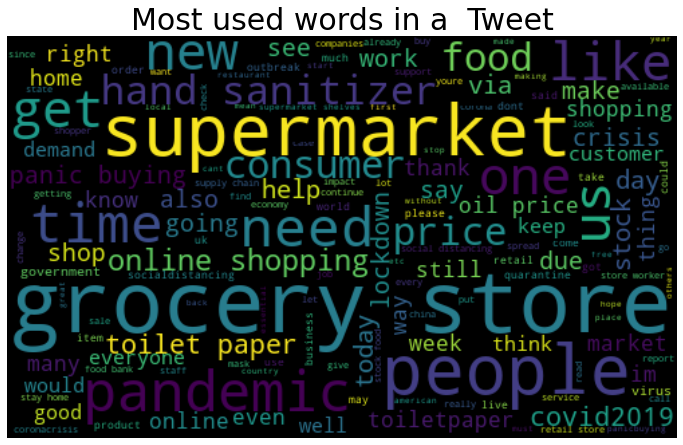

In [60]:
draw_wordcloud(df['OriginalTweet'], '')


pca

In [ ]:
!pip install texthero

In [63]:
import texthero as th

n_df = df.copy()
n_df['tfidf'] = th.tfidf(
    n_df['OriginalTweet'], max_features=400
    )

n_df['pca'] = th.pca(
    n_df['tfidf']
    )

th.scatterplot(
    n_df, 
    col='pca', 
    color='Sentiment', 
    title="Sentiment Analysis Category"
)

Words used to describe positive tweets, negative and neutral tweets are not so much distingushable. From the charts above, i think the labelling might have been bias or it could be as a result of the effect the coronavirus has on everyone and everything.

## 2. Develop a prediction model 

### logistic Regression

In [64]:
# split the train and test set
train_df = df[:len(train)]
test_df = df[len(train):]

In [65]:
test_df.drop(columns='Sentiment', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
# select the feature (OriginalTweet) and the target (Sentiment)
X = train_df['OriginalTweet']
y = train_df['Sentiment']

# split into train and test set for proper evaluation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=11)

TFIDF are word frequency scores that try to highlight words that are more interesting, e.g frequent in a document but not accross documents. In Our case, documents are tweets.

The TfidfVectorizer will tokenize documents i.e split each word in a document into a list, learn the vocabulary i.e understand which word or words occur in this or that document and inverse document frequency weightings and compute the weight based on number of occurence per document and accross document then allow you to encode new documents

In [67]:
# import vectorizers to transform data into sparse vectors


# calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), smooth_idf=False, stop_words='english', max_df=0.8,)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [68]:
# fitting the model 
log_reg = LogisticRegression(max_iter=500,)

log_reg.fit(X_train_tfidf, y_train)
preds = log_reg.predict(X_test_tfidf)

In [69]:
acc = accuracy_score(y_test, preds) * 100
f1 = f1_score(y_test, preds, average='weighted') * 100

print(f'Accuracy Score:: {acc:.2f}%')
print(f'F1 Score:: {f1:.2f}%')
print('classification report\n', classification_report(y_test, preds))

Accuracy Score:: 72.69%
F1 Score:: 71.76%
classification report
               precision    recall  f1-score   support

           0       0.73      0.76      0.75      3032
           1       0.68      0.42      0.52      1553
           2       0.74      0.83      0.78      3647

    accuracy                           0.73      8232
   macro avg       0.71      0.67      0.68      8232
weighted avg       0.72      0.73      0.72      8232



Removing the Neutral Sentiment will not be a bad idea, it makes the data looks imbalance and the model could not really understand it intricacies, mostly due to size of neutral tweets in the dataset.

In [70]:
# subset the test tweets
test_data = test_df['OriginalTweet']
# transform the tweets
test_data_transformed = tf_idf.transform(test_data)

### Implementing a LSTM classifier


I think that predicting if a tweet has a neutral sentiment is not really a solid use case so dropping all tweets of neutral sentiments.

Tokenizer is used vectorize and convert text into sequence so the Network can deal with it as input

In [71]:
train_df_no_neutral = train_df[train_df['Sentiment'] != 1]

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_df_no_neutral['OriginalTweet'].values)

print("Negative Sentiment", train_df[train_df['Sentiment'] == 0].size)
print("Positive Sentiment", train_df[train_df['Sentiment'] == 2].size)


X_lstm = tokenizer.texts_to_sequences(train_df_no_neutral['OriginalTweet'].values)
X_lstm = pad_sequences(X_lstm)

Negative Sentiment 92388
Positive Sentiment 108276


I used the softmax as the activation function because the Network will be using a categorical crossentropy. Also, specified some hyperparameters like embed_dim, lstm_out, batch_size

In [72]:
embed_dim = 128
lstm_out = 190

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_lstm.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 128)           256000    
_________________________________________________________________
lstm (LSTM)                  (None, 190)               242440    
_________________________________________________________________
dense (Dense)                (None, 2)                 382       
Total params: 498,822
Trainable params: 498,822
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
y_lstm = pd.get_dummies(train_df_no_neutral['Sentiment'])
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=91)

print(X_train_lstm.shape, X_test_lstm.shape)
print(y_train_lstm.shape, y_test_lstm.shape)

(26755, 60) (6689, 60)
(26755, 2) (6689, 2)


Training the Neural LSTM

In [76]:
batch_size=32
epochs = 10

model.fit(X_train_lstm, y_train_lstm, epochs=epochs, verbose=1,)

Epoch 1/10
837/837 [==============================] - 143s 170ms/step - loss: 0.1025 - accuracy: 0.9607
Epoch 2/10
837/837 [==============================] - 142s 170ms/step - loss: 0.0832 - accuracy: 0.9689
Epoch 3/10
837/837 [==============================] - 142s 170ms/step - loss: 0.0712 - accuracy: 0.9736
Epoch 4/10
837/837 [==============================] - 142s 170ms/step - loss: 0.0698 - accuracy: 0.9745
Epoch 5/10
837/837 [==============================] - 141s 169ms/step - loss: 0.0492 - accuracy: 0.9822
Epoch 6/10
837/837 [==============================] - 142s 170ms/step - loss: 0.0442 - accuracy: 0.9839
Epoch 7/10
837/837 [==============================] - 141s 169ms/step - loss: 0.0399 - accuracy: 0.9862
Epoch 8/10
837/837 [==============================] - 141s 169ms/step - loss: 0.0406 - accuracy: 0.9855
Epoch 9/10
837/837 [==============================] - 142s 170ms/step - loss: 0.0343 - accuracy: 0.9881
Epoch 10/10
837/837 [==============================] - 143s 171m

In [77]:
validation_size=3000

X_validate = X_test_lstm[-validation_size:]
y_validate = y_test_lstm[-validation_size:]
X_tes = X_test_lstm[:-validation_size]
y_tes = y_test_lstm[:-validation_size]

score, acc = model.evaluate(X_tes, y_tes, verbose=2, batch_size=batch_size)

116/116 - 6s - loss: 1.0131 - accuracy: 0.8249


### Results

LSTM Model Performed Better than Logistic Regression

    No Surprises as Neural Network has more sophiscated algorithms embeded.
    
    Tweets Originates from USA, so it makes sense that most mentioned users were prominent people in USA

    Most Tweets that were classified as containing negative sentiments were mostly because of hike in price of food stuff.

    Result show that realDonanldTrump is the most mentioned user, well he was the president so he should listen to the peoples blame more.

    Since the dataset was about coronavirus or was gathered during the period of coronavirus most used words were coronavirus, covid19, stayHomeSafeLives etc

  Thank You 